In [184]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import get_sun
from astropy.time import Time
from astropy.coordinates import FK5
from astropy.coordinates import SkyCoord
import uncertainties as u

In [179]:
#Get declination and right ascension of the sun at a given time
time1 = Time('2022-9-25 12:00:00') #The time
sun = get_sun(time1)

sun_coord = SkyCoord(ra=sun.ra.degree*u.degree, dec=sun.dec.degree*u.degree, frame='icrs') #transform the sun coordinates to FK5
sun_coord.galactic

sun_coord_fk5 = sun_coord.transform_to(FK5(equinox='J2022.9')) #precess to a different equinox
sun_coord.transform_to(FK5(equinox='J2022.9'))

print("Copy Method: ", sun_coord_fk5.ra*u.degree, sun_coord_fk5.dec*u.degree)
print("Native Transform", sun_coord)

Copy Method:  182.21237755139268 deg2 -0.9585435276974851 deg2
Native Transform <SkyCoord (ICRS): (ra, dec) in deg
    (181.91889427, -0.83114161)>


In [182]:
#formula to calculate the latitude of Ojai
# Latitude = arctan (cos(RA) * shadow_length / stick_length) * pi/180 + Dec

def latitude_calc(stick_length, shadow_length, sun_dec, sun_ra):
    latitude = np.arctan(np.cos(sun_ra) * shadow_length / stick_length) * (180/np.pi) + sun_dec
    return latitude


In [ ]:
#mean and standard deviation of the measured lengths of the shadow and stick 

#measurments of the shadow and stick
shadow_error = 0.5 #cm
shadow_lengths = [20.2, 21.1, 20.6, 20.5, 20.5, 20.9] #cm 
stick_error = 0.5 #cm
stick_lengths = [26.6, 26.7, 26.5, 26.6, 26.6, 26.5]

sun_ra = sun_coord.ra.degree #right ascension of the sun in degrees

sun_dec = sun_coord.dec.degree #declination of the sun in degrees

#calculate the latitude for each of these measuremnts 
latitudes = []
for i in range(len(shadow_lengths)):
    lat = latitude_calc(stick_lengths[i], shadow_lengths[i], sun_dec, sun_ra)
    print(stick_lengths[i], shadow_lengths[i], sun_dec, sun_ra)
    latitudes.append(lat)

print(latitudes)


26.6 20.2 -0.8311416065000898 181.91889427231345
26.7 21.1 -0.8311416065000898 181.91889427231345
26.5 20.6 -0.8311416065000898 181.91889427231345
26.6 20.5 -0.8311416065000898 181.91889427231345
26.6 20.5 -0.8311416065000898 181.91889427231345
26.5 20.9 -0.8311416065000898 181.91889427231345
[35.1833466064219, 36.27537932762567, 35.82256912896656, 35.5859790474695, 35.5859790474695, 36.220120665426165]


[1.0766584327215563, 1.0778554040699722, 1.0837905165275334, 1.0785795646684384, 1.0785795646684384, 1.0857205777369963]


/var/folders/fq/ms8x0fbn5jncb3hwt2r8w7rh0000gn/T/ipykernel_6571/368298208.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  final /= np.float(len(latitudes))


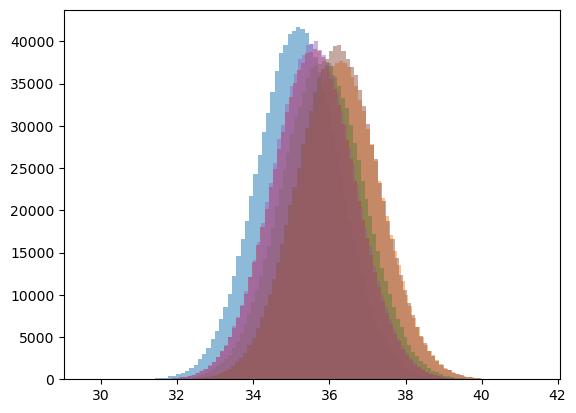

In [ ]:
#Calculate the error propagation for the latitude
def calc_error(stick_length, stick_error, shadow_length, shadow_error, sun_dec, sun_ra):
    latitude = latitude_calc(stick_length, shadow_length, sun_dec, sun_ra)
    error = np.sqrt((np.cos(sun_ra) * stick_error / stick_length)**2 + (shadow_error / shadow_length)**2) * latitude
    return error

#calculate the error for each of the measurements
errors = []
for i in range(len(shadow_lengths)):
    error = calc_error(stick_lengths[i], stick_error, shadow_lengths[i], shadow_error, sun_dec, sun_ra)
    errors.append(error)

print(errors)


plt.figure(1)
for i in range(len(latitudes)):
    plt.hist(np.random.normal(latitudes[i], errors[i], 1000000), bins=100, alpha=0.5, label='Measurement ' + str(i+1))

final = []
i = 0
for val in latitudes:
    if i == 0:
        final = np.random.normal(val,0.5,1000000)
    else:
        final += np.random.normal(val,0.5,1000000)
    i += 1

final /= np.float(len(latitudes))
plt.hist(final,bins=100,alpha=1,color='black',density=True)

plt.show()


/var/folders/fq/ms8x0fbn5jncb3hwt2r8w7rh0000gn/T/ipykernel_6571/2689261066.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  final /= np.float(n)


The mean and standard deviation of the measurements: 35.78 +/- 0.50
The mean and standard deviation of the mean of the measurements: 35.78 +/- 0.20


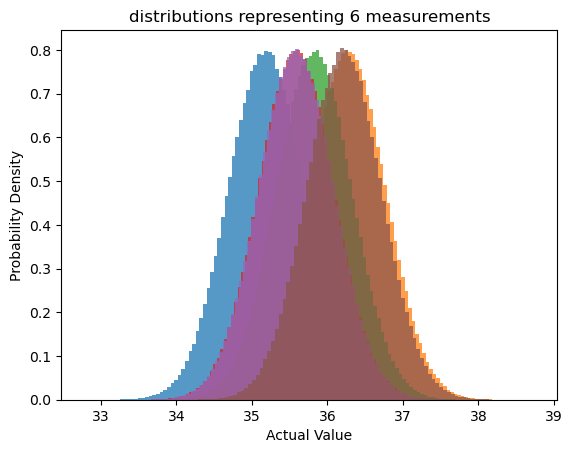

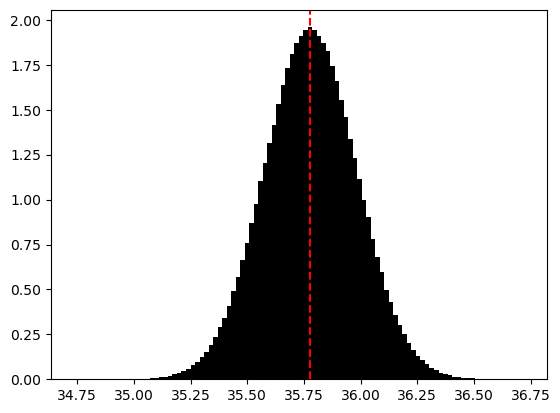

In [ ]:
plt.figure(2)
sigma = 0.5
sz = 1000000
bins = 100
numbers = latitudes
mean = np.mean(latitudes)
n = len(latitudes)

plt.clf()
for val in numbers:
    plt.hist(np.random.normal(val,sigma,sz),bins=bins,alpha=0.75,density=True)

plt.xlabel('Actual Value')
plt.ylabel('Probability Density')
plt.title('distributions representing '+str(n)+' measurements')

# -- Take the mean of all these distributions
final = []
i = 0
for val in numbers:
    if i == 0:
        final = np.random.normal(val,sigma,sz)
    else:
        final += np.random.normal(val,sigma,sz)
    i += 1
    
final /= np.float(n)

plt.figure(4)
plt.hist(final,bins=bins,alpha=1,color='black',density=True)
plt.axvline(x=mean,linestyle='--',color='red')

print('The mean and standard deviation of the measurements: %.2f +/- %.2f'%(mean,sigma))
print('The mean and standard deviation of the mean of the measurements: %.2f +/- %.2f'% \
      (np.mean(final),np.std(final,ddof=1)))

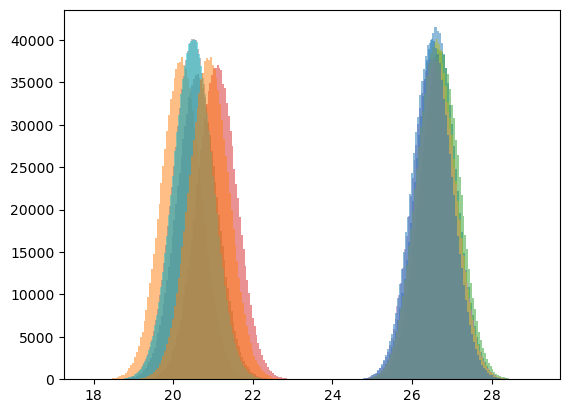

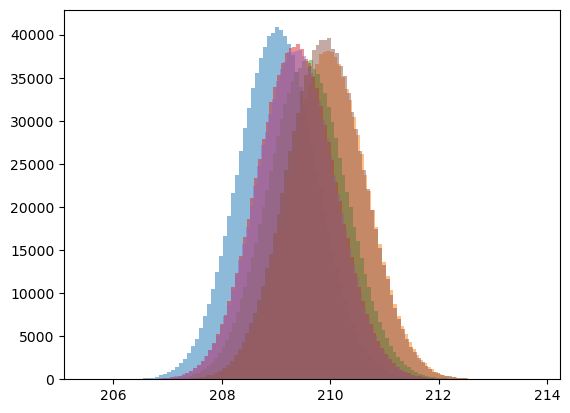

In [183]:
sz = 1000000
astropy_error = 0.00000001

sun_ra_dist = np.random.normal(sun_dec, astropy_error, sz)
sun_dec_dist = np.random.normal(sun_ra, astropy_error, sz)

plt.figure(3)
stick_lengths_dist = []
shadow_lengths_dist = []
for i in range(len(stick_lengths)):
    stick_lengths_dist.append(np.random.normal(stick_lengths[i], stick_error, sz))
    shadow_lengths_dist.append(np.random.normal(shadow_lengths[i], shadow_error, sz))
    plt.hist(stick_lengths_dist[i], bins=100, alpha=0.5, label='Stick Length ' + str(i+1))
    plt.hist(shadow_lengths_dist[i], bins=100, alpha=0.5, label='Shadow Length ' + str(i+1))

plt.show()
plt.figure(4)

latitudes_dist = []
for i in range(len(stick_lengths)):
    latitudes_dist.append(latitude_calc(stick_lengths_dist[i], shadow_lengths_dist[i], sun_dec_dist, sun_ra_dist))
    plt.hist(latitudes_dist[i], bins=100, alpha=0.5, label='Measurement ' )

plt.show()
